# Homework 4: MLE and MAP

In [358]:
import numpy as np
import matplotlib.pyplot as plt
import math

## 1. Definition of the test problem

In [359]:
# CREATE A TEST PROBLEM

N = 150 # Number of datapoints
K = 3   # Correct degree+1 of polynomial

# Define the domain
a, b = 0, 1

# Define the true solution
theta_true = np.ones((K,))

# Define the dataset
X = np.linspace(a, b, N)

In [360]:
# Definition of the Generalized Vandermonde matrix
def vander(X, K):
    """
    Given a feature vector X and the parameter K, returns the
    Vandermonde matrix associated with vector X.
    
    Parameters:
        - X: Feature vector to be computed the vandermonde matrix
        - K: Number of columns the matrix should have.

    Returns:
        - Phi: The Vandermonde matrix associated with X.
    """

    N = len(X)
    Phi = np.empty((N, K))

    for i in range(K):
        Phi[:, i] = X**i

    return Phi

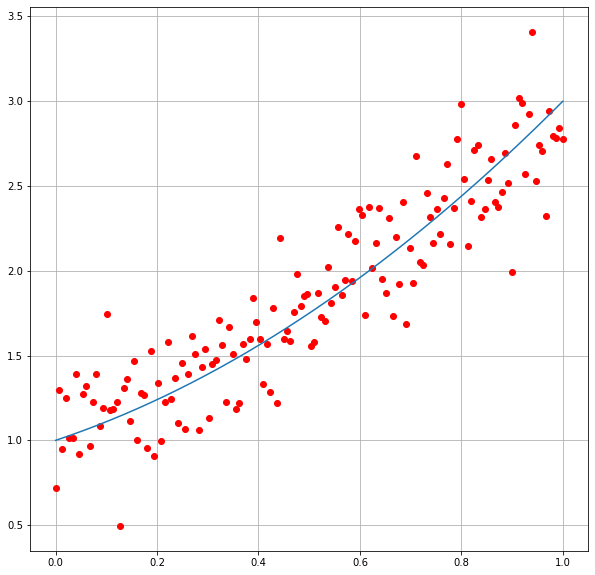

In [361]:
# Define Y such that theta_true is the solution of Phi(X)*theta = Y
Phi = vander(X, K)
Y = Phi @ theta_true

# CORRUPT Y WITH NOISE
sigma = .25  # Variance of the noise
Y = Y + sigma*np.random.normal(0, 1, Y.shape) # Its the same as defining N(0, sqrt(0.1))

# Plot X against Y, with red dots (not continuous line)
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(X, Y, 'ro')
plt.plot(X, Phi@theta_true)
plt.show()

## 2. Build a dataset $D = {(X, Y)}$ such that $\theta_{true} = (1, 1, ..., 1)^T$ is the best solution to the LS problem

In [362]:
Dtrain = (X, Y)

In [363]:
# GENERATE TEST DATASET

Ntest = 50 # Number of datapoints

# Define the new dataset using same parameters of training dataset
X = np.linspace(a, b, Ntest)

# Define Y such that theta_true is the solution of Phi(X)*theta = Y
Phi = vander(X, K)
Y = Phi @ theta_true

# CORRUPT Y WITH NOISE
Y = Y + sigma*np.random.normal(0, 1, Y.shape) # Its the same as defining N(0, sqrt(0.1))

Dtest = (X, Y)

## 3. Approximate $\theta_{true}$ by MLE and MAP

### Approximation by MLE

In [364]:
def MLE(D, K, method='normal'):
    """
    Approximate the solution to the LS problem of the by using MLE method
    dataset D.

    Parameters:
        - D: Dataset to be computed the solution.
        - K: Degree of the polynome to use as approximation.
        - method: Method to optimize the theta vector.
            * 'normal': Stands for normal equations method
            * 'GD': Stands for Gradient Descent method
            * 'SGD': Stands for Stochastic Gradient Descent method
    Returns:
        - theta: Approximate solution to the LS problem.
    """

    X, Y = D

    # Get the vandermonde matrix.
    Phi = vander(X, K)

    # Get theta by normal equations (We could also use GD or SGD here)
    if method == 'normal':
        theta = np.linalg.solve(Phi.T @ Phi, Phi.T @ Y)
    elif method == 'GD':
        w0 = np.ones((K,))
        theta = GD(grad_MLE, w0, D, tolf=0, tolx=0, kmax=100, alpha=0.1)
    elif method == 'SGD':
        theta = SGD(grad_MLE, D, batch_size=20, n_epochs=10)
    else:
        raise Exception

    return theta

In [365]:
def regressor_error(theta, Dtest):
    """
    Compute the average absolute error of a polynomila regressor that
    uses theta as parameters over Xtest.

    Parameters:
        - theta: Set of K-dimensional parameter vectors.
        - Dtest: Test dataset.
    Returns:
        - error: Average absolute error of the polynomial regressor over Dtest.
    """

    Xtest, Ytest = Dtest
    Ntest = Xtest.shape[0]
    Nregressors = len(theta)
    error = 0

    for theta_vector in theta:

        k = len(theta_vector)   # Get the dimension of the parameter vector
        Phi = vander(Xtest, k)  # Compute Phi

        Yhat = Phi@theta_vector

        error += (1/Ntest)*(np.linalg.norm(Yhat - Ytest)**2)

    error /= Nregressors

    return error

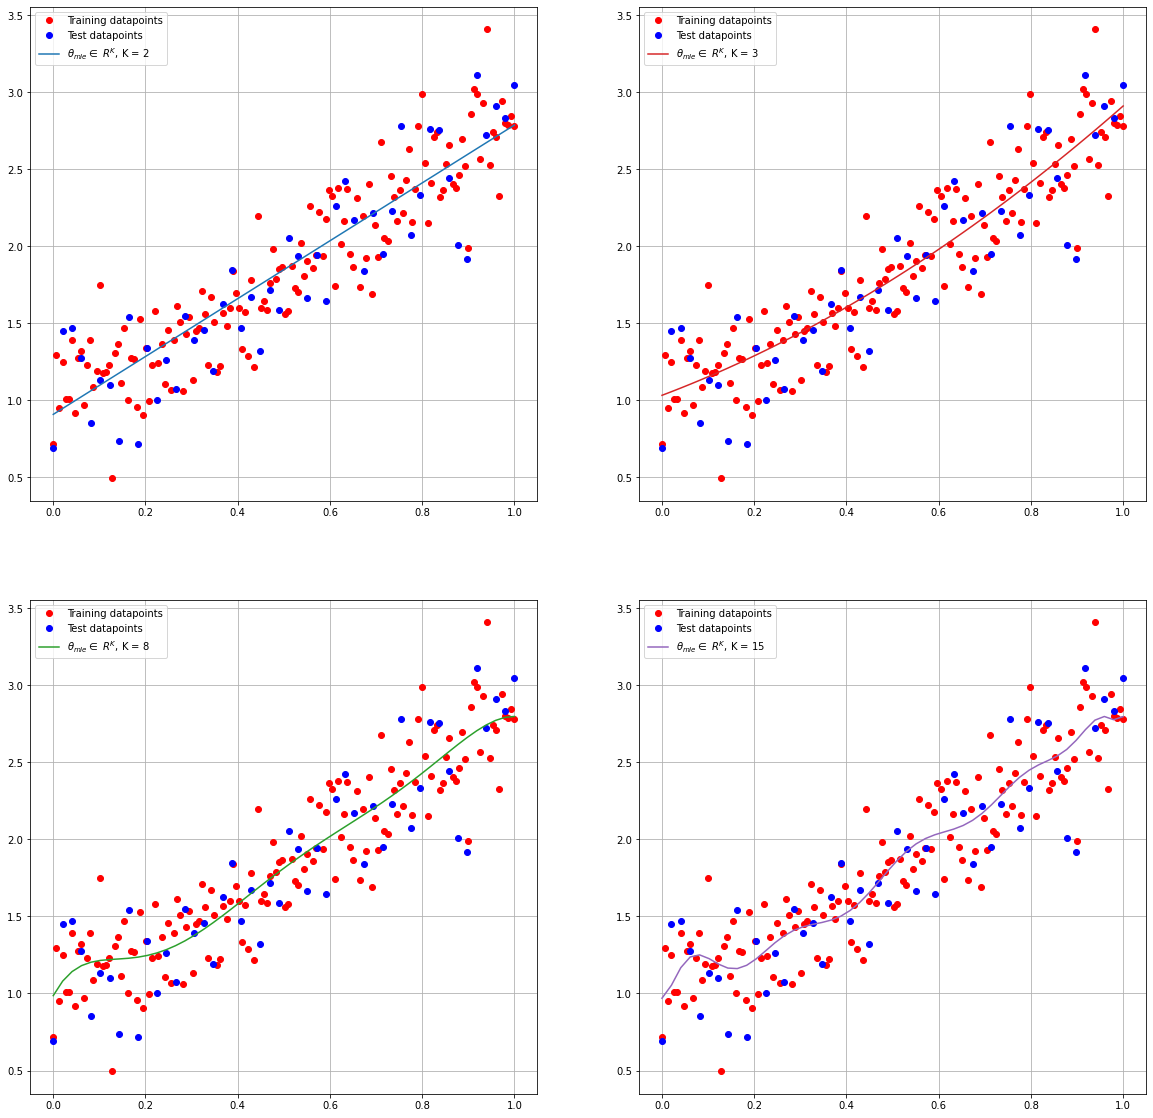

In [366]:
# Here we get the error for each regressor with every K in [2, 20]
dims = 20                   # Number values for K
Kvector = np.arange(2, dims+1)     # Different values of K to test
theta = []                  # Vector that contains the different parameter vectors

# Get a theta_mle for each K
for k in Kvector:
    theta_mle = MLE(Dtrain, k)
    theta.append(theta_mle)

# PLOT RESULTS 
Ktest = [2, 3, 8, 15]   # We dont want to plot all of them, just these ones.
plt.figure(figsize=(20,20))                         # Set figure
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple'] # Set colors for the solutions
for (i, k) in zip(range(1, len(Ktest)+1), Ktest):

    plt.subplot(2, 2, i)                            # Define the subplot
    plt.grid()                                      # Set the grid
    # Plot training and test data points
    plt.plot(Dtrain[0], Dtrain[1], 'ro')            # Train data
    plt.plot(Dtest[0], Dtest[1], 'bo')              # Test data
    # Define and plot the legend
    names = []
    names.append("Training datapoints")
    names.append("Test datapoints")
    names.append(r'$\theta_{mle} \in$ $R^K$, K = ' + str(k))
    # Plot the solution to the problem
    Phi = vander(X, k)
    plt.plot(X, Phi@theta[k-2], color=colors[i-1])  # Compute the solution with the regressor f_theta(X) = Phi(X)@theta
    plt.legend(names) # We have to add the lengend at the end, otherwise, it wont be displayed
plt.show()

Notice the line that best approximate the test datapoints is the one with $\theta_{mle} \in R^3$ not only because is the correct K, but also because it allows the regressor to be flexible enough. We can notice the regressor with $\theta_{mle} \in R^{20}$ approximates better the training datapoints, but this means that will also catch noise if it exists.

In [367]:
test_err = []
train_err = []

for theta_vec in theta:

    err = regressor_error([theta_vec], Dtrain)
    train_err.append(err)

    err = regressor_error([theta_vec], Dtest)
    test_err.append(err)

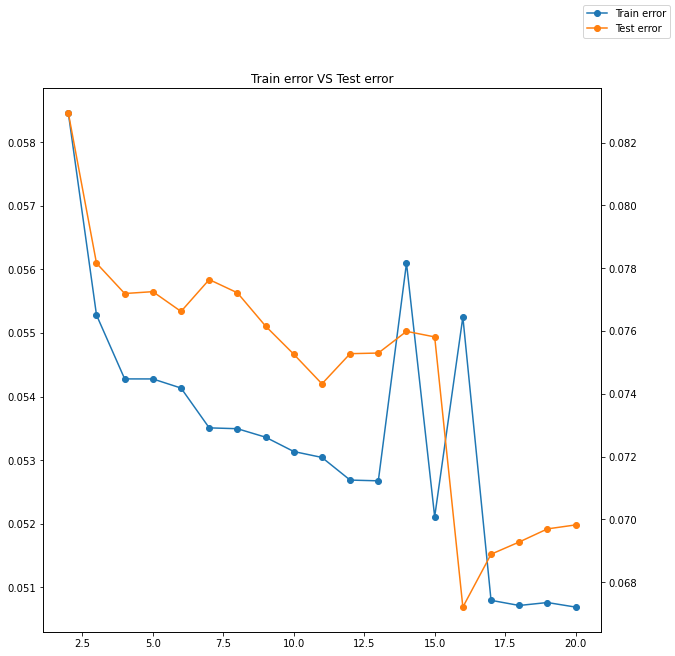

In [368]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 10)

ax1.plot(Kvector,train_err, marker='o')
ax1.set_title('Train error VS Test error')

ax2 = ax1.twinx()
ax2.plot(Kvector,test_err,'C1', marker='o')

fig.legend(["Train error", "Test error"])
plt.show()

### Approximation by MAP

In [369]:
def MAP(D, K, ld, method='normal'):
    """
    Approximate the solution to the LS problem of the by using MAP method
    dataset D.

    Parameters:
        - D: Dataset to be computed the solution.
        - K: Degree of the polynome to use as approximation.
        - ld: Lambda parameter of the MAP method
    Returns:
        - theta: Approximate solution to the LS problem.
    """

    X, Y = D

    Phi = vander(X, K)

    # Get theta by normal equations (We could also use GD or SGD here)
    if method == 'normal':
        theta = np.linalg.solve(Phi.T @ Phi + ld*np.eye(K), Phi.T @ Y)
    elif method == 'GD':
        w0 = np.random.normal(0, 0.25, (K, 1))
        theta = GD(grad_MAP(ld), w0, D, tolf=0, tolx=0, kmax=100, alpha=0.1)
    elif method == 'SGD':
        theta = SGD(grad_MAP(ld), D, batch_size=20, n_epochs=10)
    else:
        raise Exception

    return theta

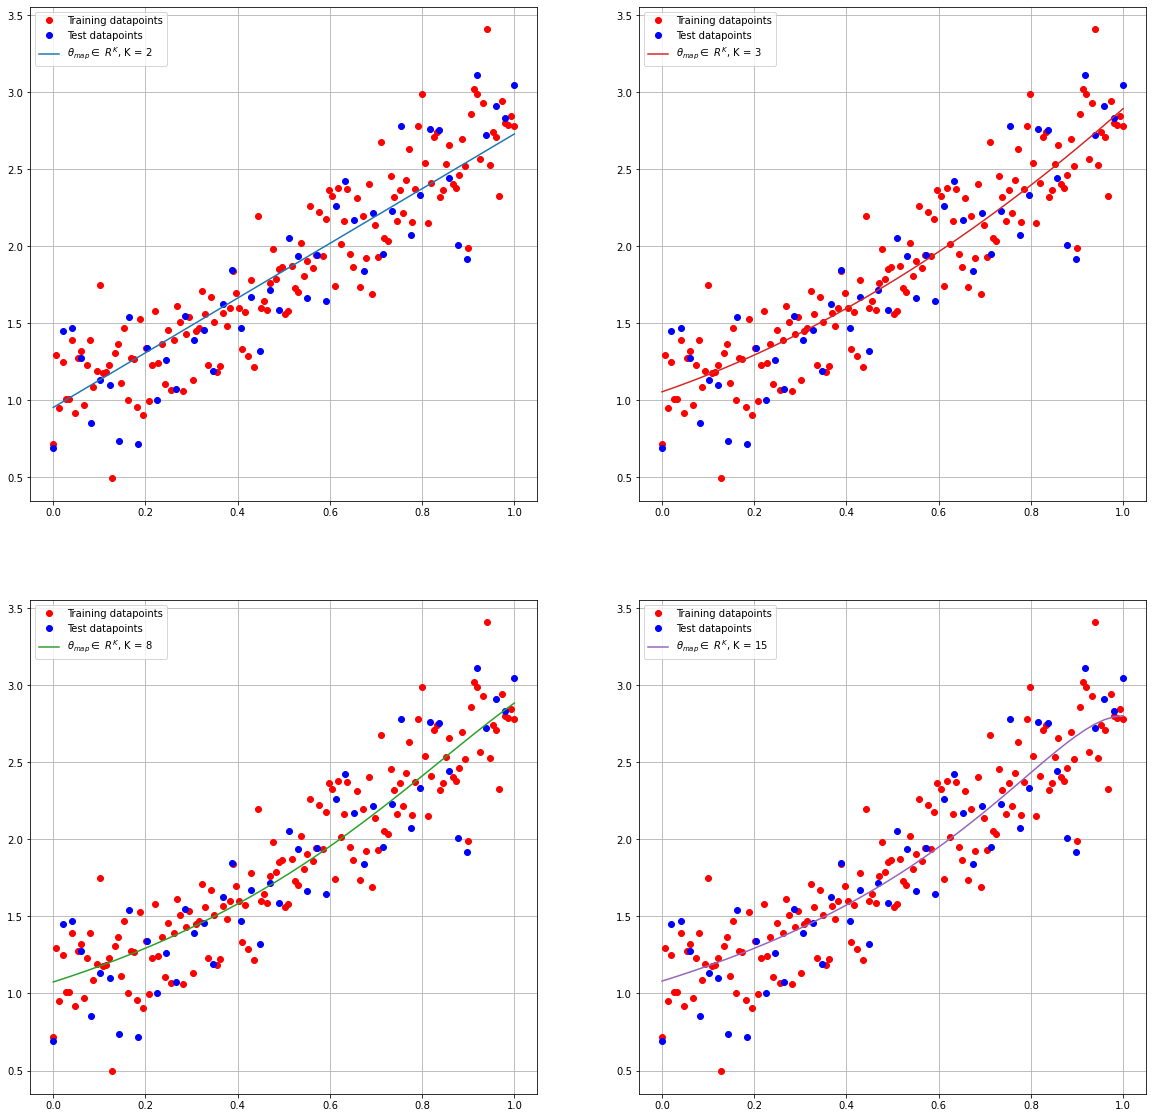

In [370]:
# Here we get the error for each regressor with every K in [2, 20]
dims = 20                   # Number values for K
Kvector = np.arange(2, dims+1)     # Different values of K to test
theta = []                  # Vector that contains the different parameter vectors

# Get a theta_mle for each K
for k in Kvector:
    theta_map = MAP(Dtrain, k, ld=1)
    theta.append(theta_map)

# PLOT RESULTS 
Ktest = [2, 3, 8, 15]   # We dont want to plot all of them, just these ones.
plt.figure(figsize=(20,20))                         # Set figure
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple'] # Set colors for the solutions
for (i, k) in zip(range(1, len(Ktest)+1), Ktest):

    plt.subplot(2, 2, i)                            # Define the subplot
    plt.grid()                                      # Set the grid
    # Plot training and test data points
    plt.plot(Dtrain[0], Dtrain[1], 'ro')            # Train data
    plt.plot(Dtest[0], Dtest[1], 'bo')              # Test data
    # Define and plot the legend
    names = []
    names.append("Training datapoints")
    names.append("Test datapoints")
    names.append(r'$\theta_{map} \in$ $R^K$, K = ' + str(k))
    # Plot the solution to the problem
    Phi = vander(X, k)
    plt.plot(X, Phi@theta[k-2], color=colors[i-1])  # Compute the solution with the regressor f_theta(X) = Phi(X)@theta
    plt.legend(names) # We have to add the lengend at the end, otherwise, it wont be displayed
plt.show()

In [371]:
test_err = []
train_err = []

for theta_vec in theta:

    err = regressor_error([theta_vec], Dtrain)
    train_err.append(err)

    err = regressor_error([theta_vec], Dtest)
    test_err.append(err)

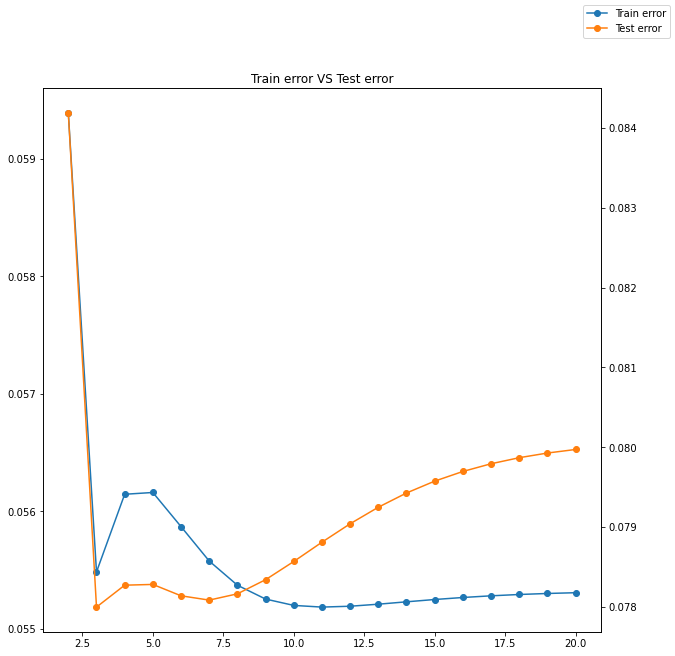

In [372]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 10)

ax1.plot(Kvector,train_err,marker='o')
ax1.set_title('Train error VS Test error')

ax2 = ax1.twinx()
ax2.plot(Kvector,test_err,'C1',marker='o')

fig.legend(["Train error", "Test error"])
plt.show()

In [373]:
K = 100
theta_mle = MLE(Dtrain, K)
theta_map_1 = MAP(Dtrain, K, ld=1)
theta_map_2 = MAP(Dtrain, K, ld=5)
theta_map_3 = MAP(Dtrain, K, ld=20)

print(f"Regressor error of MLE: {regressor_error([theta_mle], Dtest)}")
print(f"Regressor error of MAP with lambda = 1: {regressor_error([theta_map_1], Dtest)}")
print(f"Regressor error of MAP with lambda = 5: {regressor_error([theta_map_2], Dtest)}")
print(f"Regressor error of MAP with lambda = 20: {regressor_error([theta_map_3], Dtest)}")

Regressor error of MLE: 0.07044752488949303
Regressor error of MAP with lambda = 1: 0.07997508194307687
Regressor error of MAP with lambda = 5: 0.08260140495251371
Regressor error of MAP with lambda = 20: 0.10004695026658839


In [374]:
Kvector = np.arange(3, 9)
mle_errors = []
map1_errors = []
map2_errors = []
map3_errors = []

for k in Kvector:
    theta_mle = MLE(Dtrain, k)
    theta_map1 = MAP(Dtrain, k, ld=1)
    theta_map2 = MAP(Dtrain, k, ld=5)
    theta_map3 = MAP(Dtrain, k, ld=20)

    padded_theta = np.zeros((k,))
    padded_theta[:theta_true.shape[0]] = theta_true[:]

    # Compute the error
    err_mle = np.linalg.norm(theta_mle - padded_theta) / np.linalg.norm(padded_theta)
    err_mpa1 = np.linalg.norm(theta_map1 - padded_theta) / np.linalg.norm(padded_theta)
    err_mpa2 = np.linalg.norm(theta_map2 - padded_theta) / np.linalg.norm(padded_theta)
    err_mpa3 = np.linalg.norm(theta_map3 - padded_theta) / np.linalg.norm(padded_theta)
    
    mle_errors.append(err_mle)
    map1_errors.append(err_mpa1)
    map2_errors.append(err_mpa2)
    map3_errors.append(err_mpa3)

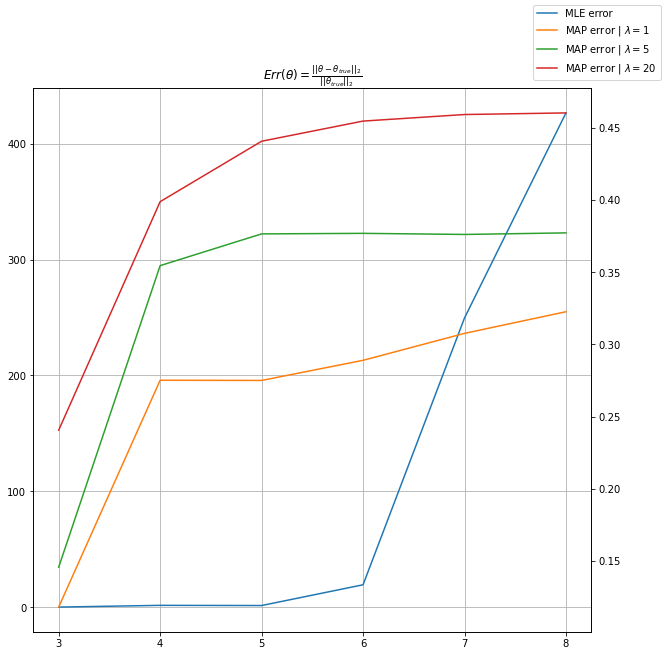

In [375]:
fig, ax1 = plt.subplots()
ax1.grid()
fig.set_size_inches(10, 10)

ax1.plot(Kvector, mle_errors)
ax1.set_title(r"$Err(\theta)=\frac{||\theta - \theta_{true}||_2}{||\theta_{true}||_2}$")

ax2 = ax1.twinx()
ax2.plot(Kvector, map1_errors, 'C1')
ax2.plot(Kvector, map2_errors, 'C2')
ax2.plot(Kvector, map3_errors, 'C3')

fig.legend(["MLE error", r"MAP error | $\lambda=1$", r"MAP error | $\lambda=5$", r"MAP error | $\lambda=20$"])
plt.show()

### Comparison with GD and SGD

In [376]:
def GD(grad_f, w0, data, tolf, tolx, kmax, alpha=1e-5):

    # Initialization
    k = 0           # Iterations index
    
    # Define stopping criterias
    stpCr1 = np.linalg.norm(grad_f(w0, data)) < tolf*np.linalg.norm(w0)
    stpCr2 = np.linalg.norm((grad_f(w0, data) - grad_f(w0, data))) < tolx*np.linalg.norm(w0)
    stpCr3 = k >= kmax
    conditions = stpCr1 or stpCr2 or stpCr3

    while not conditions:

        print(np.linalg.norm(grad_f(w0, data)))
        wk = w0 - alpha*grad_f(w0, data)          # Update x
        k += 1                                      # Update k
        # Compute the error of the gradient to check the condition
        err_val = np.linalg.norm(grad_f(wk, data))

        # Update conditions
        stpCr1 = err_val < tolf*np.linalg.norm(w0)
        stpCr2 = np.linalg.norm((grad_f(wk, data) - grad_f(w0, data))) < tolx*np.linalg.norm(w0)
        stpCr3 = k >= kmax
        conditions = stpCr1 or stpCr2 or stpCr3

        # Restart 
        w0 = wk

    return wk

In [377]:
def SGD(grad_l, w0, data, batch_size, n_epochs):

    X, Y = data         # Extract data
    N = X.shape[0]      # Get the dimensionality of the problem

    # Calculate the number of batches per epoch
    n_batch_iters = N // batch_size
    print(f"Number of batch iterations to be performed: {n_batch_iters}")

    alpha = 1e-3     # Fix step length

    # Epoch loop
    for epoch in range(n_epochs):

        # This is just to have some feedback on the screen while executing
        print(f"Epoch {epoch+1}/{n_epochs}")
        
        # Create a back-up of the dataset
        X_backup = np.copy(X)
        Y_backup = np.copy(Y)

        # Batch iteration
        for k in range(n_batch_iters):
            
            # Get again the dimensionality of the problem
            # It will change since each epoch we are reducing the number of samples in the whole dataset
            d, N = X.shape

            # Classical random sampling using index
            idx = np.arange(N)
            np.random.shuffle(idx)  #TODO Search for a way of doing this with random seed
            batch_idx = idx[:batch_size]

            # Extract the batch from the data
            Mx = X[:, batch_idx]  # d x batch_size
            My = Y[batch_idx]     # batch_size

            # Remove the batches from the original dataset
            X = np.delete(X, batch_idx, axis=1)
            Y = np.delete(Y, batch_idx)

            # Update w
            # TODO Perform the gradient aproximation outside of the function
            w = w0 - alpha*grad_l(w0, (Mx, My))

            # Restart 
            w0 = w
        
        # Reload X and Y
        X = X_backup
        Y = Y_backup
        # ATTENTION: Shuffle again (differently)

    return w

In [378]:
def grad_MLE(w, D):
    X, Y = D
    K = len(w)
    Phi = vander(X, K)
    return (Phi.T @ ((Phi @ w) - Y)).T

def grad_MAP(w, D, ld):
    X, Y = D
    K = len(w)
    Phi = vander(X, K)
    return ((Phi.T @ ((Phi @ w) - Y)) + ld*w).T

In [379]:
theta_mle_GD = MLE(Dtrain, 3, 'GD')
theta_mle = MLE(Dtrain, 3)

2.353812038137715
20.868290836925393
418.86394505740583
8439.21151147801
170033.2104435835
3425828.701588858
69023588.1700885
1390687083.0011356
28019559893.93658
564538023144.39
11374310688039.863
229169583489628.12
4617308198907670.0
9.302951412251829e+16
1.8743584194616356e+18
3.776456877953667e+19
7.608804379655344e+20
1.5330217174155332e+22
3.08873177545685e+23
6.223176013970905e+24
1.2538453487154808e+26
2.52624729714546e+27
5.089882426786357e+28
1.0255093849197646e+30
2.066196054006921e+31
4.162971296384372e+32
8.387553533902028e+33
1.6899240776695655e+35
3.404858611923215e+36
6.860108285559623e+37
1.3821744469742193e+39
2.784804732441107e+40
5.610823883196153e+41
1.1304686566173857e+43
2.277667968552134e+44
4.589044857281907e+45
9.246006438564662e+46
1.8628851475776183e+48
3.753340532611629e+49
7.562229572802145e+50
1.5236378264876367e+52
3.069825114346218e+53
6.185082877861484e+54
1.2461703445983614e+56
2.5107837007567044e+57
5.058726376623344e+58
1.019232064706815e+60
2.05354

In [380]:
err = regressor_error(theta_mle_GD.T, Dtest)

TypeError: object of type 'numpy.float64' has no len()

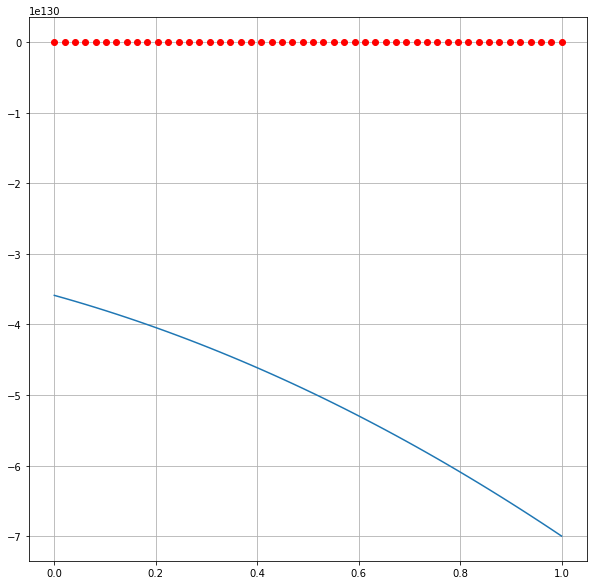

In [ ]:
# Define Y such that theta_true is the solution of Phi(X)*theta = Y
X, Y = Dtest
Phi = vander(X, 3)
Y = Phi @ theta_true

# CORRUPT Y WITH NOISE
sigma = .25  # Variance of the noise
Y = Y + sigma*np.random.normal(0, 1, Y.shape) # Its the same as defining N(0, sqrt(0.1))

# Plot X against Y, with red dots (not continuous line)
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(X, Y, 'ro')
plt.plot(X, Phi@theta_mle_GD)
plt.show()

## 4. Approximation of $\theta_true$ assuming a Poisson distribution

In [ ]:
# CREATE A TEST PROBLEM

N = 80 # Number of datapoints
K = 3   # Correct degree+1 of polynomial

# Define the domain
a, b = 0, 1

# Define the true solution
theta_true = np.ones((K,))

# Define the dataset
X = np.linspace(a, b, N)

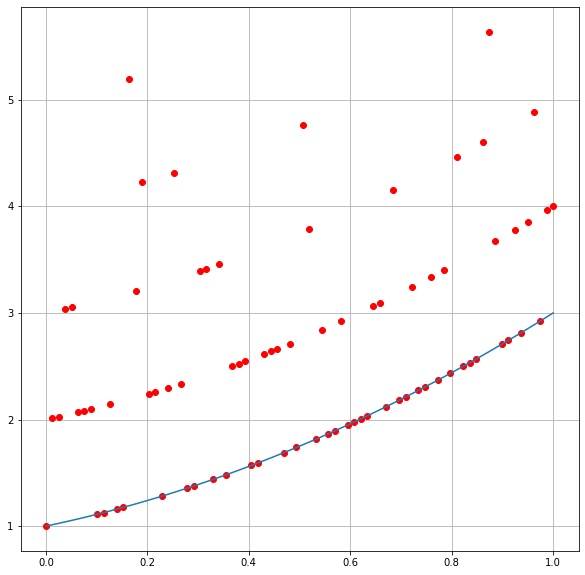

In [ ]:
# Define Y such that theta_true is the solution of Phi(X)*theta = Y
Phi = vander(X, K)
Y = Phi @ theta_true

# CORRUPT Y WITH NOISE
lam = 1  # Variance of the noise
Y = Y + np.random.poisson(lam, Y.shape) # Its the same as defining Poi(y|1)

# Plot X against Y, with red dots (not continuous line)
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(X, Y, 'ro')
plt.plot(X, Phi@theta_true)
plt.show()

In [ ]:
Dtrain = (X, Y)

In [ ]:
# GENERATE TEST DATASET

Ntest = 20 # Number of datapoints

# Define the new dataset using same parameters of training dataset
X = np.linspace(a, b, Ntest)

# Define Y such that theta_true is the solution of Phi(X)*theta = Y
Phi = vander(X, K)
Y = Phi @ theta_true

# CORRUPT Y WITH NOISE
Y = Y + np.random.poisson(lam, Y.shape) # Its the same as defining N(0, sqrt(0.1))

Dtest = (X, Y)

## 5. MLE and MAP for Poisson assumption

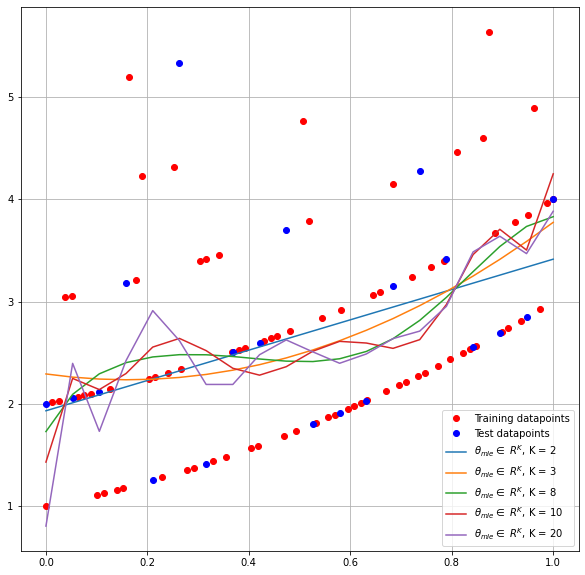

In [ ]:
Kvector = [2, 3, 8, 10, 20]    # Different values of K to test
theta = []                  # Vector that contains the different parameter vectors
names = []                  # Names for the legend of the plot

# Get a theta_mle for each K
for k in Kvector:
    theta_mle = MLE(Dtrain, k)
    theta.append(theta_mle)

# Tets the different regressors
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(Dtrain[0], Dtrain[1], 'ro')            # Train data
plt.plot(Dtest[0], Dtest[1], 'bo')              # Test data
names.append("Training datapoints")
names.append("Test datapoints")


for theta_vec, k in zip(theta, Kvector):

    names.append(r'$\theta_{mle} \in$ $R^K$, K = ' + str(k))
    Phi = vander(X, k)
    plt.plot(X, Phi@theta_vec)  # Compute the solution with the regressor f_theta(X) = Phi(X)@theta

plt.legend(names)
plt.show()